In [53]:
import pandas as pd #import important libraries
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error,mean_squared_error
import xgboost as xgb
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import optuna
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
df = pd.read_csv(r"C:\Users\trainee\Desktop\knn_imputed_dataset_finalll.csv") #read dataset

In [55]:
print("Shape of dataset: ", df.shape) #size of dataset

Shape of dataset:  (1900168, 14)


In [56]:
print(df.head()) #overview of dataframe

     DEPT     RHOB     RHOC      DPOR        GR     RILM      RLL3      RILD  \
0  3185.5  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   
1  3185.0  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   
2  3184.5  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   
3  3184.0  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   
4  3183.5  2.44338  0.05724  15.59248  61.69454  17.1619  11.00546  13.27408   

        MN      CNLS     WELL_ID  WELL_INDEX       phi       sw  
0  4.78984  25.10352  1055282622       124.0  0.155925  0.55665  
1  4.78984  25.10352  1055282622       124.0  0.155925  0.55665  
2  4.78984  25.10352  1055282622       124.0  0.155925  0.55665  
3  4.78984  25.10352  1055282622       124.0  0.155925  0.55665  
4  4.78984  25.10352  1055282622       124.0  0.155925  0.55665  


In [57]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 411773


In [ ]:
# Drop duplicate rows
df = df.drop_duplicates()

df = df.reset_index(drop=True)

print("Duplicates removed. New shape:", df.shape)

Duplicates removed. New shape: (1488395, 14)


In [59]:
df = df.drop(columns=['DPOR', 'RHOB'])

In [60]:
print(df.head())

     DEPT     RHOC        GR     RILM      RLL3      RILD       MN      CNLS  \
0  3185.5  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   
1  3185.0  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   
2  3184.5  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   
3  3184.0  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   
4  3183.5  0.05724  61.69454  17.1619  11.00546  13.27408  4.78984  25.10352   

      WELL_ID  WELL_INDEX       phi       sw  
0  1055282622       124.0  0.155925  0.55665  
1  1055282622       124.0  0.155925  0.55665  
2  1055282622       124.0  0.155925  0.55665  
3  1055282622       124.0  0.155925  0.55665  
4  1055282622       124.0  0.155925  0.55665  


In [61]:
ignore_cols = ['WELL_ID', 'WELL_INDEX']

# Keep ignored ID columns separately if you want
X_ignore = df[ignore_cols]

In [ ]:
# Define target columns
target_columns = ['sw', 'phi']

X_features = df.drop(columns = ignore_cols + target_columns)

y1 = df['sw']
y2 = df['phi']

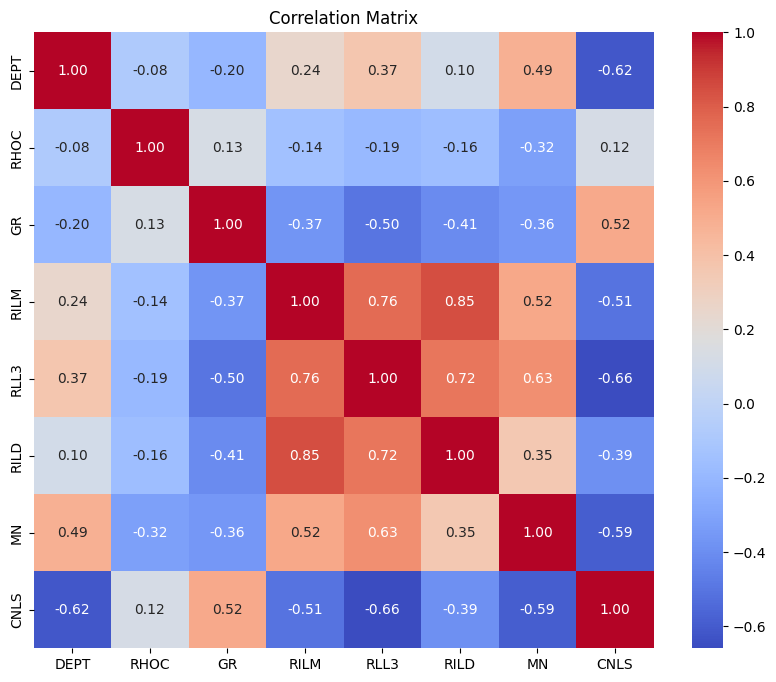

In [63]:
plt.figure(figsize=(10, 8))
sn.heatmap(X_features.corr(),annot=True ,fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
#sampling
from sklearn.model_selection import train_test_split
import pandas as pd

# Bin y1 (sw) into 3 equal-frequency bins (quantiles)
y1_bins = pd.qcut(y1, q=3, labels=False, duplicates='drop')

# Bin y2 (phi) the same way — 3 bins.
y2_bins = pd.qcut(y2, q=3, labels=False, duplicates='drop')

combined_bins = y1_bins * 10 + y2_bins

#  Count how many samples are in each combined bin.
bin_counts = combined_bins.value_counts()


valid_bins = bin_counts[bin_counts >= 2].index

# Create a boolean mask selecting only valid samples.
valid_mask = combined_bins.isin(valid_bins)


X_valid = X_features[valid_mask]       
X_ignore_valid = X_ignore[valid_mask]  
y1_valid = y1[valid_mask]              
y2_valid = y2[valid_mask]             
combined_bins_valid = combined_bins[valid_mask]  

#  60% training, 40% temp (to be split into val/test)
X_train, X_temp, y1_train, y1_temp, y2_train, y2_temp, bins_train, bins_temp = train_test_split(
    X_valid, y1_valid, y2_valid, combined_bins_valid,
    test_size=0.4,              # 40% goes to temp
    stratify=combined_bins_valid,
    random_state=42
)

# Split temp into val/test:
X_val, X_test, y1_val, y1_test, y2_val, y2_test = train_test_split(
    X_temp, y1_temp, y2_temp,
    test_size=0.5,      # half of temp = 20% of original
    stratify=bins_temp,
    random_state=42
)

# Keep your WELL_ID and WELL_INDEX for each split:
X_train_ignore = X_ignore_valid.loc[X_train.index]
X_val_ignore = X_ignore_valid.loc[X_val.index]
X_test_ignore = X_ignore_valid.loc[X_test.index]

In [ ]:
#scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled   = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [66]:
#ANN
def create_ann_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [ ]:
#ANN for y1 sw
from tensorflow.keras.callbacks import EarlyStopping

train_df_y1 = pd.concat([pd.DataFrame(X_train_scaled, index=X_train.index), y1_train], axis=1).dropna()

X_train_y1 = train_df_y1.drop(columns=[y1_train.name])
y1_train_clean = train_df_y1[y1_train.name]

X_test_scaled_y1 = pd.DataFrame(X_test_scaled, index=X_test.index)[X_train_y1.columns]

ann_model_y1 = create_ann_model(input_dim=X_train_y1.shape[1])
early_stop = EarlyStopping(patience=30, restore_best_weights=True)

ann_model_y1.fit(
    X_train_y1, y1_train_clean,
    validation_split=0.2,
    epochs=300,
    batch_size=24,
    callbacks=[early_stop],
    verbose=0
)

y1_pred_ann = ann_model_y1.predict(X_test_scaled_y1).flatten()

C:\Users\trainee\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9303/9303 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [ ]:
#ANN for y2 phi

train_df_y2 = pd.concat([pd.DataFrame(X_train_scaled, index=X_train.index), y2_train], axis=1).dropna()

X_train_y2 = train_df_y2.drop(columns=[y2_train.name])
y2_train_clean = train_df_y2[y2_train.name]

X_test_scaled_y2 = pd.DataFrame(X_test_scaled, index=X_test.index)[X_train_y2.columns]

ann_model_y2 = create_ann_model(X_train_y2.shape[1])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

ann_model_y2.fit(
    X_train_y2, y2_train_clean,
    validation_split=0.2,
    epochs=200,
    batch_size=24,
    callbacks=[early_stop],
    verbose=0
)

y2_pred_ann = ann_model_y2.predict(X_test_scaled_y2).flatten()

C:\Users\trainee\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9303/9303 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


In [69]:
def evaluate_model(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\nEvaluation for {label}:")
    print(f"R2 Score : {r2:.4f}")
    print(f"RMSE     : {rmse:.4f}")
    print(f"MAE      : {mae:.4f}")

In [70]:
print("Artificial Neural Network (ANN):")

# y1 (sw)
y1_pred_series = pd.Series(y1_pred_ann, index=y1_test.index)
combined_y1 = pd.concat([y1_test, y1_pred_series], axis=1).dropna()
evaluate_model(combined_y1.iloc[:, 0], combined_y1.iloc[:, 1], "sw (ANN)")

# y2 (phi)
y2_pred_series = pd.Series(y2_pred_ann, index=y2_test.index)
combined_y2 = pd.concat([y2_test, y2_pred_series], axis=1).dropna()
evaluate_model(combined_y2.iloc[:, 0], combined_y2.iloc[:, 1], "phi (ANN)")

Artificial Neural Network (ANN):

Evaluation for sw (ANN):
R2 Score : 0.7495
RMSE     : 0.1586
MAE      : 0.1043

Evaluation for phi (ANN):
R2 Score : 0.7178
RMSE     : 0.0920
MAE      : 0.0602


In [71]:
#RF
# SW-specific RF params
rf_para_sw = {
    'n_estimators': 257,
    'max_depth': 25,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'bootstrap': True,
    'random_state': 42
}

# PHI-specific RF params
rf_para_phi = {
    'n_estimators': 300,
    'max_depth': 27,
    'min_samples_split': 3,
    'min_samples_leaf': 2,
    'bootstrap': True,
    'random_state': 42
}

In [72]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Clean and prepare for y1 (sw)
train_data_y1 = pd.concat([X_train, y1_train], axis=1).dropna()
X_train_y1 = train_data_y1.drop(columns=y1_train.name)
y1_train_clean = train_data_y1[y1_train.name]

rf_y1 = RandomForestRegressor(**rf_para_sw)
rf_y1.fit(X_train_y1, y1_train_clean)
y1_pred_rf = rf_y1.predict(X_test[X_train_y1.columns])

# Clean and prepare for y2 (phi)
train_data_y2 = pd.concat([X_train, y2_train], axis=1).dropna()
X_train_y2 = train_data_y2.drop(columns=y2_train.name)
y2_train_clean = train_data_y2[y2_train.name]

rf_y2 = RandomForestRegressor(**rf_para_phi)
rf_y2.fit(X_train_y2, y2_train_clean)
y2_pred_rf = rf_y2.predict(X_test[X_train_y2.columns])

In [73]:
#XGB
# SW-specific XGB params
xgb_para_sw = {
    'n_estimators': 289,
    'max_depth': 15,
    'learning_rate': 0.0385140457876012,
    'subsample': 0.7856057077437046,
    'colsample_bytree': 0.9033691395479809,
    'random_state': 42,
}

# PHI-specific XGB params
xgb_para_phi = {
    'n_estimators': 168,
    'max_depth': 15,
    'learning_rate': 0.07584462014824686,
    'subsample': 0.7133042588177481,
    'colsample_bytree': 0.9733012344082324,
    'random_state': 42,
}

In [74]:
from xgboost import XGBRegressor
import pandas as pd

def prepare_training_data(X, y):
    data = pd.concat([X, y], axis=1).dropna()
    X_clean = data.drop(columns=y.name)
    y_clean = data[y.name]
    return X_clean, y_clean

# y1 (sw)
X_train_y1, y1_train_clean = prepare_training_data(X_train_scaled, y1_train)
X_test_y1 = X_test_scaled[X_train_y1.columns]

xgb_model_y1 = XGBRegressor(**xgb_para_sw)
xgb_model_y1.fit(X_train_y1, y1_train_clean)
y1_pred_xgb = xgb_model_y1.predict(X_test_y1)

# y2 (phi)
X_train_y2, y2_train_clean = prepare_training_data(X_train_scaled, y2_train)
X_test_y2 = X_test_scaled[X_train_y2.columns]

xgb_model_y2 = XGBRegressor(**xgb_para_phi)
xgb_model_y2.fit(X_train_y2, y2_train_clean)
y2_pred_xgb = xgb_model_y2.predict(X_test_y2)

In [ ]:
#KNN

knn_para_sw = {
    'n_neighbors': 15,
    'weights': 'distance',
    'p': 1
}

knn_para_phi = {
    'n_neighbors': 15,
    'weights': 'distance',
    'p': 1
}

In [76]:
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

# y1 (sw) — use scaled X
train_data_y1 = pd.concat([X_train_scaled, y1_train], axis=1).dropna()
X_train_y1 = train_data_y1.drop(columns=y1_train.name)
y1_train_clean = train_data_y1[y1_train.name]

knn_model_y1 = KNeighborsRegressor(**knn_para_sw)
knn_model_y1.fit(X_train_y1, y1_train_clean)
y1_pred_knn = knn_model_y1.predict(X_test_scaled[X_train_y1.columns])

# y2 (phi) — use scaled X
train_data_y2 = pd.concat([X_train_scaled, y2_train], axis=1).dropna()
X_train_y2 = train_data_y2.drop(columns=y2_train.name)
y2_train_clean = train_data_y2[y2_train.name]

knn_model_y2 = KNeighborsRegressor(**knn_para_phi)
knn_model_y2.fit(X_train_y2, y2_train_clean)
y2_pred_knn = knn_model_y2.predict(X_test_scaled[X_train_y2.columns])

In [77]:
#Results

def evaluate_model(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5

    print(f"\nResults for {name}")
    print(f"R² Score : {r2:.4f}")
    print(f"RMSE     : {rmse:.4f}")
    print(f"MSE      : {mse:.4f}")

In [78]:
print("Random Forest:")

# y1 (sw)
y1_pred_series_rf = pd.Series(y1_pred_rf, index=y1_test.index)
combined_y1_rf = pd.concat([y1_test, y1_pred_series_rf], axis=1).dropna()
evaluate_model(combined_y1_rf.iloc[:, 0], combined_y1_rf.iloc[:, 1], "sw (RF)")

# y2 (phi)
y2_pred_series_rf = pd.Series(y2_pred_rf, index=y2_test.index)
combined_y2_rf = pd.concat([y2_test, y2_pred_series_rf], axis=1).dropna()
evaluate_model(combined_y2_rf.iloc[:, 0], combined_y2_rf.iloc[:, 1], "phi (RF)")

Random Forest:

Results for sw (RF)
R² Score : 0.8206
RMSE     : 0.1342
MSE      : 0.0180

Results for phi (RF)
R² Score : 0.8148
RMSE     : 0.0745
MSE      : 0.0056


In [79]:
print("XGBoost:")

# y1 (sw)
y1_pred_series_xgb = pd.Series(y1_pred_xgb, index=y1_test.index)
combined_y1_xgb = pd.concat([y1_test, y1_pred_series_xgb], axis=1).dropna()
evaluate_model(combined_y1_xgb.iloc[:, 0], combined_y1_xgb.iloc[:, 1], "sw (XGB)")

# y2 (phi)
y2_pred_series_xgb = pd.Series(y2_pred_xgb, index=y2_test.index)
combined_y2_xgb = pd.concat([y2_test, y2_pred_series_xgb], axis=1).dropna()
evaluate_model(combined_y2_xgb.iloc[:, 0], combined_y2_xgb.iloc[:, 1], "phi (XGB)")

XGBoost:

Results for sw (XGB)
R² Score : 0.8277
RMSE     : 0.1315
MSE      : 0.0173

Results for phi (XGB)
R² Score : 0.8157
RMSE     : 0.0743
MSE      : 0.0055


In [80]:
print("KNN:")

# y1 (sw)
y1_pred_series_knn = pd.Series(y1_pred_knn, index=y1_test.index)
combined_y1_knn = pd.concat([y1_test, y1_pred_series_knn], axis=1).dropna()
evaluate_model(combined_y1_knn.iloc[:, 0], combined_y1_knn.iloc[:, 1], "sw (KNN)")

# y2 (phi)
y2_pred_series_knn = pd.Series(y2_pred_knn, index=y2_test.index)
combined_y2_knn = pd.concat([y2_test, y2_pred_series_knn], axis=1).dropna()
evaluate_model(combined_y2_knn.iloc[:, 0], combined_y2_knn.iloc[:, 1], "phi (KNN)")

KNN:

Results for sw (KNN)
R² Score : 0.7731
RMSE     : 0.1509
MSE      : 0.0228

Results for phi (KNN)
R² Score : 0.7520
RMSE     : 0.0862
MSE      : 0.0074


In [ ]:
#Ensembling: STACKING KNN RF XGB
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd

meta_model = Ridge()

base_estimators_sw = [
    ('knn', KNeighborsRegressor(**knn_para_sw)),
    ('rf', RandomForestRegressor(**rf_para_sw)),
    ('xgb', XGBRegressor(**xgb_para_sw, verbosity=0))
]

base_estimators_phi = [
    ('knn', KNeighborsRegressor(**knn_para_phi)),
    ('rf', RandomForestRegressor(**rf_para_phi)),
    ('xgb', XGBRegressor(**xgb_para_phi, verbosity=0))
]


X_train_scaled_y1 = X_train_scaled.copy()
X_test_scaled_y1 = X_test_scaled.copy()

X_train_scaled_y2 = X_train_scaled.copy()
X_test_scaled_y2 = X_test_scaled.copy()

stack_y1 = StackingRegressor(
    estimators=base_estimators_sw,
    final_estimator=meta_model,
    passthrough=True,
    cv=5
)

stack_y1.fit(X_train_scaled_y1, y1_train)
y1_pred_stack = stack_y1.predict(X_test_scaled_y1)

y1_pred_stack_series = pd.Series(y1_pred_stack, index=y1_test.index)
combined_y1_stack = pd.concat([y1_test, y1_pred_stack_series], axis=1).dropna()

print("\nSTACKING: sw")
evaluate_model(combined_y1_stack.iloc[:, 0], combined_y1_stack.iloc[:, 1], "sw (Stacking)")

stack_y2 = StackingRegressor(
    estimators=base_estimators_phi,
    final_estimator=meta_model,
    passthrough=True,
    cv=5
)

stack_y2.fit(X_train_scaled_y2, y2_train)
y2_pred_stack = stack_y2.predict(X_test_scaled_y2)

y2_pred_stack_series = pd.Series(y2_pred_stack, index=y2_test.index)
combined_y2_stack = pd.concat([y2_test, y2_pred_stack_series], axis=1).dropna()

print("\nSTACKING: phi")
evaluate_model(combined_y2_stack.iloc[:, 0], combined_y2_stack.iloc[:, 1], "phi (Stacking)")


STACKING: sw

Results for sw (Stacking)
R² Score : 0.8309
RMSE     : 0.1303
MSE      : 0.0170

STACKING: phi

Results for phi (Stacking)
R² Score : 0.8230
RMSE     : 0.0728
MSE      : 0.0053


In [ ]:
# ENSEMBLE: RF KNN ANN
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y1_pred_ann = np.array(y1_pred_ann)   # ANN for sw
y1_pred_rf = np.array(y1_pred_rf)     # RF for sw
y1_pred_knn = np.array(y1_pred_knn)   # KNN for sw

y2_pred_ann = np.array(y2_pred_ann)   # ANN for phi
y2_pred_rf = np.array(y2_pred_rf)     # RF for phi
y2_pred_knn = np.array(y2_pred_knn)   # KNN for phi

# Weights for sw (y1)
w1_ann = 0.6
w1_rf = 0.3
w1_knn = 0.1

# Weights for phi (y2)
w2_ann = 0.03
w2_rf = 0.95
w2_knn = 0.02

# Weighted average predictions
y1_pred_ensemble = w1_ann * y1_pred_ann + w1_rf * y1_pred_rf + w1_knn * y1_pred_knn
y2_pred_ensemble = w2_ann * y2_pred_ann + w2_rf * y2_pred_rf + w2_knn * y2_pred_knn

y1_ensemble_df = pd.concat(
    [y1_test, pd.Series(y1_pred_ensemble, index=y1_test.index)],
    axis=1
).dropna()

y2_ensemble_df = pd.concat(
    [y2_test, pd.Series(y2_pred_ensemble, index=y2_test.index)],
    axis=1
).dropna()

def evaluate_model(y_true, y_pred, name):
    print(f"\nWeighted Ensemble Results for {name}")
    print(f"R² Score : {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE     : {mean_squared_error(y_true, y_pred):.4f}")
    print(f"MAE      : {mean_absolute_error(y_true, y_pred):.4f}")

evaluate_model(y1_ensemble_df.iloc[:, 0], y1_ensemble_df.iloc[:, 1], "sw")
evaluate_model(y2_ensemble_df.iloc[:, 0], y2_ensemble_df.iloc[:, 1], "phi")


Weighted Ensemble Results for sw
R² Score : 0.7893
RMSE     : 0.0212
MAE      : 0.0953

Weighted Ensemble Results for phi
R² Score : 0.8140
RMSE     : 0.0056
MAE      : 0.0463


In [ ]:
import joblib

# Save the trained models individually
joblib.dump(stack_y1, "sw_model.pkl")
joblib.dump(stack_y2, "phi_model.pkl")

print(" Saved models: sw_model.pkl and phi_model.pkl")

✅ Saved models: sw_model.pkl and phi_model.pkl


In [ ]:
import joblib
joblib.dump(scaler, "scaler.pkl")
print(" Saved scaler as scaler.pkl")

✅ Saved scaler as scaler.pkl
